In [1]:
# Title: DMRG for Bachelor Thesis
# Author: Aaron Sander
# Date: March-April 2020

# This program is used for initial learning of tensor network methods
# to be used in my bachelor thesis.
# It is an implementation of Matrix Product States (MPS) and Density Matrix
# Renormalization Group (DMRG) for compressing an arbitrary quantum state
# which has relevant applications in data compression and graph embedding.

### NOTE: This code is written for learning purposes. It is not meant
###       to be optimized for speed/efficiency, but has readability in mind.

In [7]:
######################### IMPORTS #############################################
import math

from canonical_forms import *
#from classes import *
from compression import *
from contractions import *
import initializations as init
from metrics import *
import machine_learning as ML

import scipy
import scipy.sparse.linalg
import scipy.sparse as sparse

# Compression

The following generates a list of possible Matrix Product States with maximum bond dimensions up to that of the raw data.

In [8]:
data = init.initialize_random_normed_vector(length=512)

In [9]:
d = 2
raw_state = vector_to_left_canonical_MPS(data, phys_dim=d, num_sites=int(math.log(len(data), d)))

In [17]:
compressed_state, sim, dist = ML.compress(raw_state, bond_dim=2, threshold=1e-8, activation_function='softplus')

502199027648589
0.5021999245336946
0.5022008208245199
0.5022017165213079
0.5022026116243026
0.5022035061337499
0.5022044000498938
0.5022052933729808
0.5022061861032583
0.5022070782409733
0.5022079697863728
0.5022088607397076
0.5022097511012239
0.5022106408711743
0.5022115300498069
0.5022124186373743
0.5022133066341287
0.5022141940403207
0.502215080856204
0.5022159670820323
0.5022168527180595
0.5022177377645408
0.5022186222217319
0.5022195060898876
0.5022203893692654
0.5022212720601227
0.5022221541627168
0.5022230356773068
0.5022239166041517
0.5022247969435116
0.5022256766956461
0.5022265558608169
0.5022274344392846
0.5022283124313124
0.5022291898371625
0.5022300666570991
0.5022309428913859
0.5022318185402874
0.5022326936040687
0.5022335680829971
0.502234441977337
0.502235315287357
0.5022361880133239
0.5022370601555076
0.5022379317141757
0.5022388026895979
0.5022396730820448
0.502240542891788
0.5022414121190966
0.5022422807642448
0.5022431488275042
0.5022440163091487
0.5022448832094525


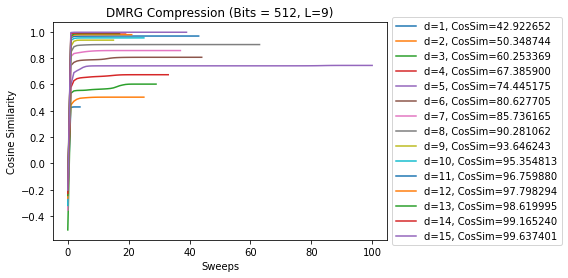

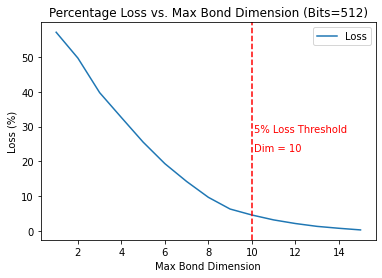

In [16]:
compressions, sim, loss = benchmark_compression(raw_state, threshold=1e-8)

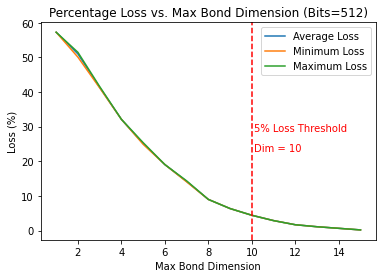

In [6]:
benchmark_compression_loss(raw_state, attempts=3)